In [1]:
#2.2. 절에서 함수 최적화를 했으니, 이 코드들을 하나로 묶어보자.

# 1.코드 합치기


In [5]:
import numpy as np
import pandas as pd
import datetime #날짜를 계산하기 위해 import 한다.

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from pandas_datareader import data as pdr #Yahoo Finance으로부터 데이터를 불러오기 위한 패키지
import yfinance as yf


In [33]:
#코드를 합쳐서 하나의 함수로 정의했다.
def knn(symbol,start_date,end_date,split_ratio,n,):

    df = yf.download(symbol,start=start_date,end=end_date)
    df = df.dropna()
        
    df1 = df[['Open','High','Low','Close','Adj Close']].copy()
    df1['gap-OpenClose'] = df1['Open'] - df1['Close']
    df1['gap-HighLow'] = df1['High'] - df1['Low']
    df1 = df1.dropna() 
        
    X = df1[['gap-OpenClose','gap-HighLow','Adj Close','Open','High','Low','Close']]
    Y = np.where(df1['Close'].shift(-1) > df1['Open'].shift(-1), 1, -1)
        
      
    X = X.reset_index(drop = False)
    X['Date'] = pd.to_datetime(X['Date']) 
    X['year_month'] = X['Date'].dt.strftime('%Y-%m')
    month_list = X['year_month'].unique() 
        
    month_list_df = pd.DataFrame()
    month_last_days = []
        
    for m in month_list:
        last_day_index = X[X['year_month'] == m].index[-1]
        month_last_days.append(X.loc[[last_day_index], :])
    month_list_df = pd.concat(month_last_days) 
    month_list_df.set_index(['Date'], inplace=True)
    
    month_list_df['1monthsAgo_Adj Close'] = month_list_df.shift(1)['Adj Close'] #1개월전 종가 데이터를 가져온다.
    month_list_df['GapOf1Month']=month_list_df['Adj Close']-month_list_df['1monthsAgo_Adj Close']
    month_list_df.fillna(0,inplace=True)
        
    X=month_list_df[['gap-OpenClose','gap-HighLow']]
    Y=np.where(month_list_df['GapOf1Month'].shift(-1) > 0,1, -1)
        
        
        
    split_ratio=split_ratio
    split = int(split_ratio*len(month_list_df))

    X_train = X[:split]
    Y_train = Y[:split]

    X_test = X[split:]
    Y_test = Y[split:]
        
        
    train_acc=[]
    test_acc=[]

    for i in range(1,n):
        clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=i) #이 함수를 통해 모델을 훈련시킨다.
        clf.fit(X_train, Y_train)
        prediction = clf.predict(X_test)
        train_acc.append(clf.score(X_train, Y_train)) #각각의 정확도들을 train_acc에 추가한다.
        test_acc.append((prediction==Y_test).mean())
            
        #최대값 출력 위한 변수
    test_max = 0
    accuracy_test_list =[]
    test_max_index=0
    for i in range(1,n):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train,Y_train)
        
        #수치에 약간의 변형을 가해서 가독성을 높인다.(100을 곱하고 %을 추가.)
        accuracy_train = accuracy_score(Y_train, knn.predict(X_train))*100 
        accuracy_test = accuracy_score(Y_test, knn.predict(X_test))*100 
        if(test_max<=accuracy_test):
            test_max=accuracy_test
            test_max_index=i
        print('훈련 정확도 : %.2f' % accuracy_train) 
        print('테스트 정확도 : %.2f' % accuracy_test)
        accuracy_test_list.append(accuracy_test)
        
        #test set의 정확도만 따로 산출해서 그린다.

    plt.figure(figsize=(30,9))
    plt.plot(range(1,n),accuracy_test_list,label='test set 정확도') 
    plt.xlabel('인접 데이터 개수') #x축에 제목을 붙인다.
    plt.ylabel("test set 정확도") #y축에 제목을 붙인다.
    plt.xticks(np.arange(0,n+1,step=1))
    plt.legend()
    
    print("최대 test set 정확도: ",test_max)
    print("최대 test set 정확도를 가진 k값: ",test_max_index)    
        

# 2.  정확도 분석(1): split_ratio 값에 따른 최대 정확도 조사 

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 46.67
훈련 정확도 : 76.69
테스트 정확도 : 38.67
훈련 정확도 : 78.04
테스트 정확도 : 52.00
훈련 정확도 : 72.97
테스트 정확도 : 41.33
훈련 정확도 : 75.00
테스트 정확도 : 49.33
훈련 정확도 : 72.64
테스트 정확도 : 42.67
훈련 정확도 : 73.99
테스트 정확도 : 52.00
훈련 정확도 : 71.96
테스트 정확도 : 45.33
훈련 정확도 : 69.93
테스트 정확도 : 49.33
훈련 정확도 : 66.89
테스트 정확도 : 50.67
훈련 정확도 : 67.57
테스트 정확도 : 54.67
훈련 정확도 : 66.89
테스트 정확도 : 53.33
훈련 정확도 : 67.91
테스트 정확도 : 56.00
훈련 정확도 : 68.58
테스트 정확도 : 52.00
최대 test set 정확도:  56.00000000000001


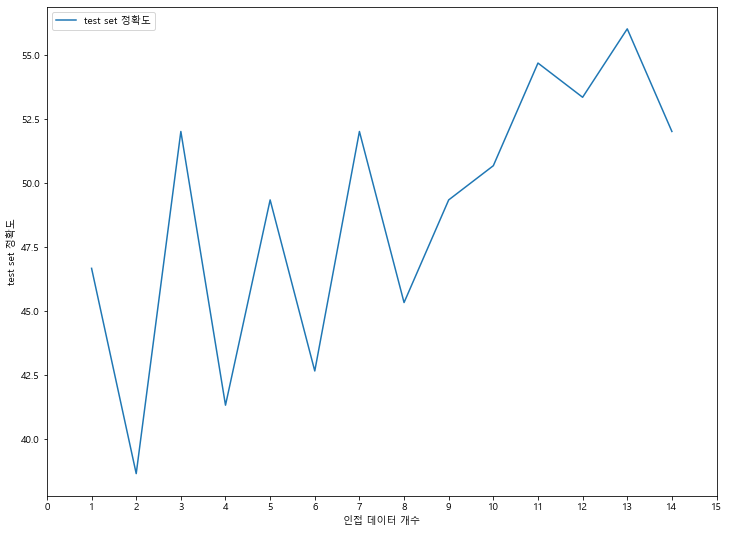

In [7]:
knn('SPY','1993-01-01','2023-11-22',0.8,15)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 50.00
훈련 정확도 : 75.38
테스트 정확도 : 28.95
훈련 정확도 : 77.18
테스트 정확도 : 44.74
훈련 정확도 : 72.97
테스트 정확도 : 31.58
훈련 정확도 : 73.87
테스트 정확도 : 42.11
훈련 정확도 : 72.37
테스트 정확도 : 36.84
훈련 정확도 : 72.67
테스트 정확도 : 47.37
훈련 정확도 : 70.27
테스트 정확도 : 39.47
훈련 정확도 : 69.37
테스트 정확도 : 50.00
훈련 정확도 : 68.17
테스트 정확도 : 44.74
훈련 정확도 : 69.37
테스트 정확도 : 55.26
훈련 정확도 : 66.07
테스트 정확도 : 50.00
훈련 정확도 : 66.97
테스트 정확도 : 55.26
훈련 정확도 : 66.37
테스트 정확도 : 55.26
최대 test set 정확도:  55.26315789473685


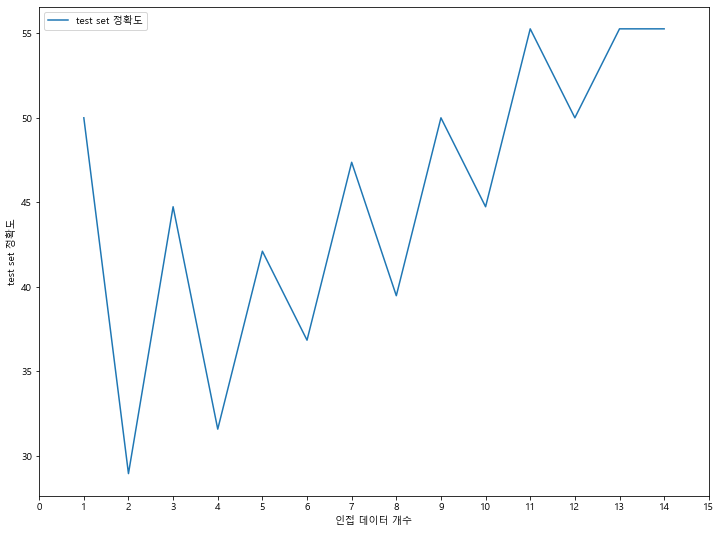

In [8]:
knn('SPY','1993-01-01','2023-11-22',0.9,15)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.21
훈련 정확도 : 77.61
테스트 정확도 : 40.18
훈련 정확도 : 79.15
테스트 정확도 : 52.68
훈련 정확도 : 72.59
테스트 정확도 : 44.64
훈련 정확도 : 74.13
테스트 정확도 : 52.68
훈련 정확도 : 72.20
테스트 정확도 : 50.00
훈련 정확도 : 71.81
테스트 정확도 : 56.25
훈련 정확도 : 70.27
테스트 정확도 : 51.79
훈련 정확도 : 70.27
테스트 정확도 : 56.25
훈련 정확도 : 68.73
테스트 정확도 : 53.57
훈련 정확도 : 67.95
테스트 정확도 : 58.04
훈련 정확도 : 66.41
테스트 정확도 : 50.89
훈련 정확도 : 66.41
테스트 정확도 : 53.57
훈련 정확도 : 69.11
테스트 정확도 : 50.89
최대 test set 정확도:  58.03571428571429


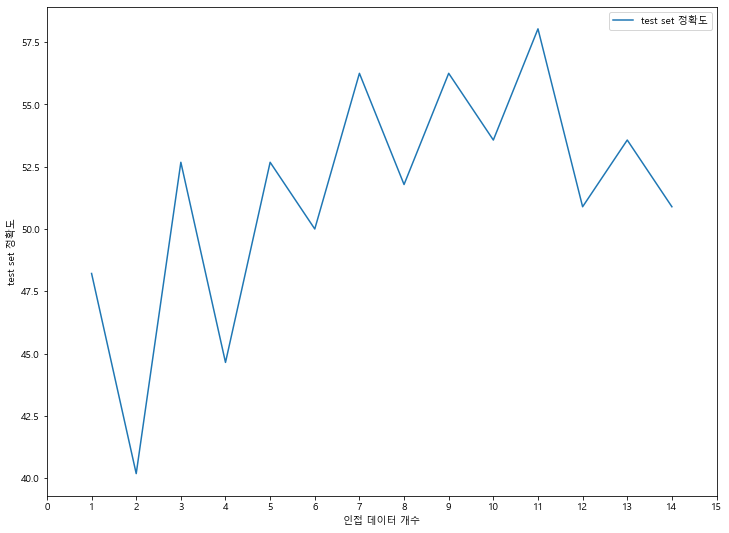

In [9]:
knn('SPY','1993-01-01','2023-11-22',0.7,15)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 49.66
훈련 정확도 : 77.93
테스트 정확도 : 38.93
훈련 정확도 : 77.93
테스트 정확도 : 53.02
훈련 정확도 : 72.07
테스트 정확도 : 44.30
훈련 정확도 : 75.23
테스트 정확도 : 57.05
훈련 정확도 : 70.27
테스트 정확도 : 48.32
훈련 정확도 : 71.62
테스트 정확도 : 55.70
훈련 정확도 : 66.22
테스트 정확도 : 42.95
훈련 정확도 : 69.37
테스트 정확도 : 55.03
훈련 정확도 : 67.12
테스트 정확도 : 46.98
훈련 정확도 : 68.02
테스트 정확도 : 55.03
훈련 정확도 : 65.77
테스트 정확도 : 51.68
훈련 정확도 : 68.92
테스트 정확도 : 53.02
훈련 정확도 : 66.22
테스트 정확도 : 53.02
최대 test set 정확도:  57.04697986577181


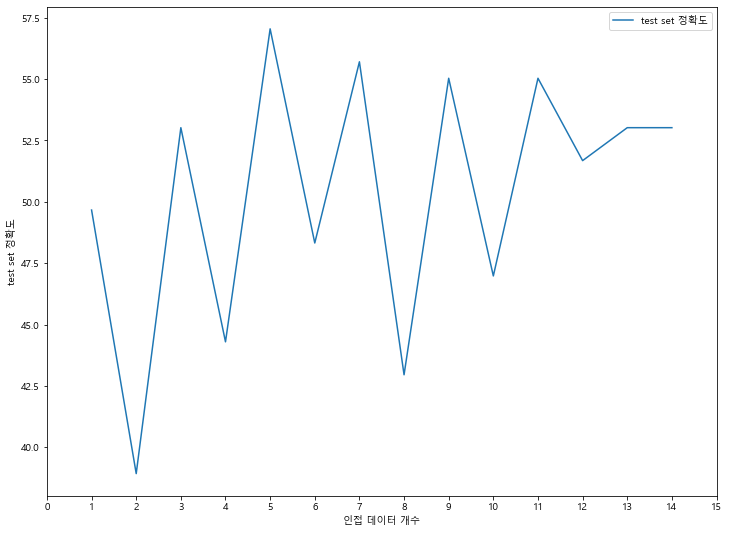

In [10]:
knn('SPY','1993-01-01','2023-11-22',0.6,15)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 81.08
테스트 정확도 : 44.09
훈련 정확도 : 77.84
테스트 정확도 : 52.15
훈련 정확도 : 74.05
테스트 정확도 : 45.70
훈련 정확도 : 75.14
테스트 정확도 : 54.30
훈련 정확도 : 72.43
테스트 정확도 : 46.77
훈련 정확도 : 72.43
테스트 정확도 : 52.15
훈련 정확도 : 69.19
테스트 정확도 : 47.85
훈련 정확도 : 68.11
테스트 정확도 : 56.99
훈련 정확도 : 70.27
테스트 정확도 : 51.61
훈련 정확도 : 70.27
테스트 정확도 : 52.69
훈련 정확도 : 67.57
테스트 정확도 : 53.23
훈련 정확도 : 68.11
테스트 정확도 : 55.38
훈련 정확도 : 67.03
테스트 정확도 : 51.08
최대 test set 정확도:  56.98924731182796


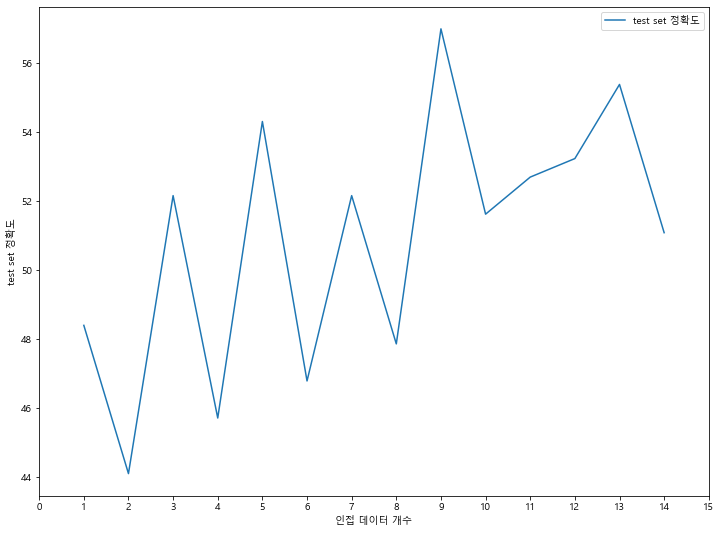

In [11]:
knn('SPY','1993-01-01','2023-11-22',0.5,15)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
훈련 정확도 : 72.66
테스트 정확도 : 51.61
훈련 정확도 : 71.22
테스트 정확도 : 46.24
훈련 정확도 : 71.94
테스트 정확도 : 55.91
훈련 정확도 : 70.14
테스트 정확도 : 50.54
훈련 정확도 : 69.78
테스트 정확도 : 55.91
훈련 정확도 : 67.63
테스트 정확도 : 50.54
훈련 정확도 : 66.19
테스트 정확도 : 55.91
훈련 정확도 : 66.55
테스트 정확도 : 48.39
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 66.55
테스트 정확도 : 50.54
최대 test set 정확도:  58.06451612903226


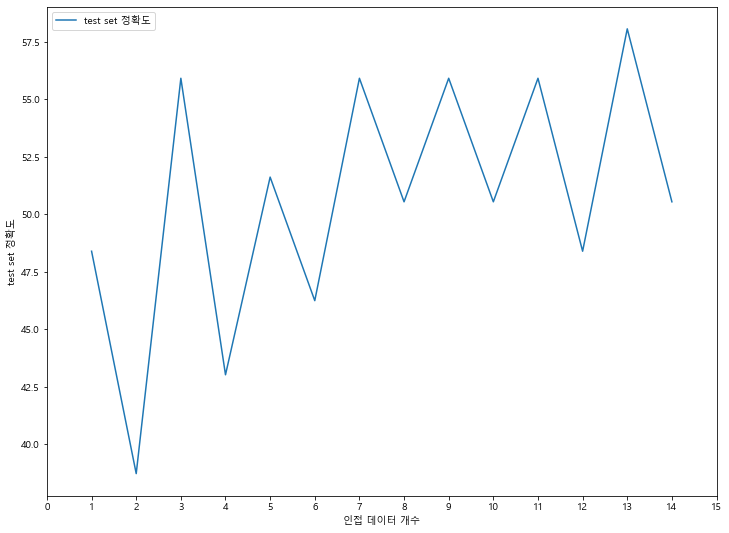

In [12]:
knn('SPY','1993-01-01','2023-11-22',0.75,15)

# 3. 2의 결과를 그래프로 나타내기

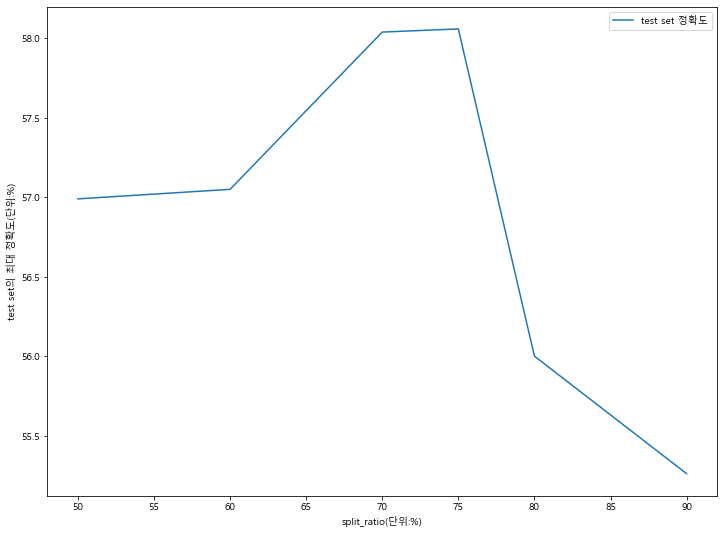

In [47]:
 plt.figure(figsize=(12,9))
plt.plot([50,60,70,75,80,90],[56.99,57.05,58.04,58.06,56.00,55.26],label='test set 정확도') 
plt.xlabel('split_ratio(단위:%)') #x축에 제목을 붙인다.
plt.ylabel("test set의 최대 정확도(단위:%)") #y축에 제목을 붙인다.
plt.legend()
plt.show()

# 4.결과1: train_set을 0.75 정도로 정하는 것이 knn 모델 성능을 최적화할 수 있다.

# 5. 정확도 분석(2): k(인접 자료)의 값에 따른 최대 정확도 조사

- split_ratio 는 최대의 정확도를 보여주는 0.75로 설정했다.

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
최대 test set 정확도:  55.91397849462365


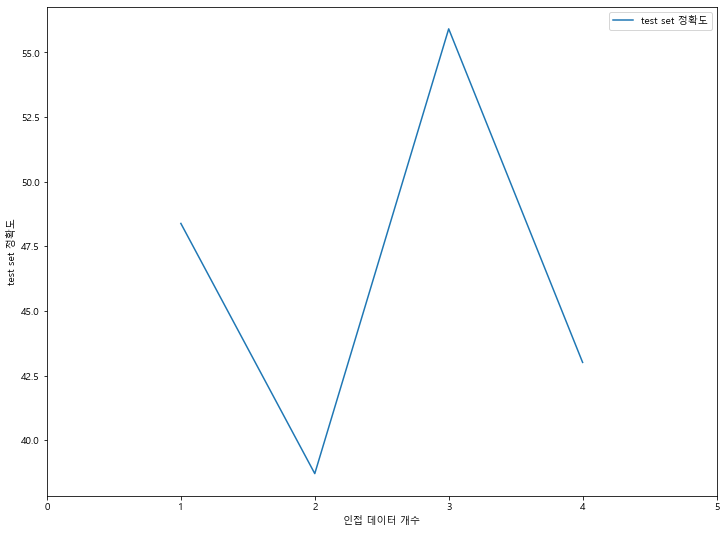

In [19]:
knn('SPY','1993-01-01','2023-11-22',0.75,5)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
훈련 정확도 : 72.66
테스트 정확도 : 51.61
훈련 정확도 : 71.22
테스트 정확도 : 46.24
훈련 정확도 : 71.94
테스트 정확도 : 55.91
훈련 정확도 : 70.14
테스트 정확도 : 50.54
훈련 정확도 : 69.78
테스트 정확도 : 55.91
최대 test set 정확도:  55.91397849462365


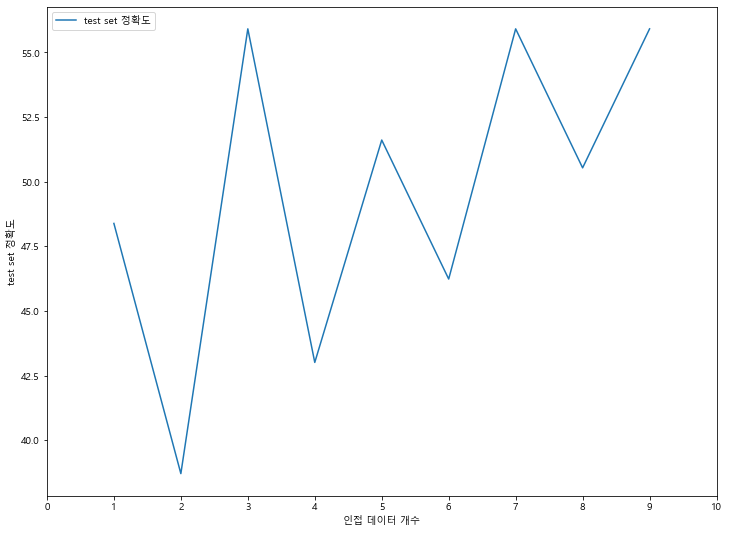

In [20]:
knn('SPY','1993-01-01','2023-11-22',0.75,10)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
훈련 정확도 : 72.66
테스트 정확도 : 51.61
훈련 정확도 : 71.22
테스트 정확도 : 46.24
훈련 정확도 : 71.94
테스트 정확도 : 55.91
훈련 정확도 : 70.14
테스트 정확도 : 50.54
훈련 정확도 : 69.78
테스트 정확도 : 55.91
훈련 정확도 : 67.63
테스트 정확도 : 50.54
훈련 정확도 : 66.19
테스트 정확도 : 55.91
훈련 정확도 : 66.55
테스트 정확도 : 48.39
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 66.55
테스트 정확도 : 50.54
최대 test set 정확도:  58.06451612903226


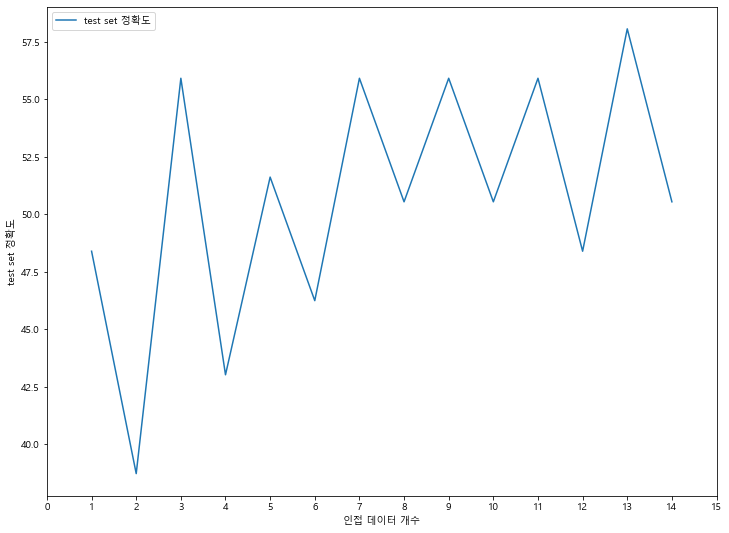

In [21]:
knn('SPY','1993-01-01','2023-11-22',0.75,15)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
훈련 정확도 : 72.66
테스트 정확도 : 51.61
훈련 정확도 : 71.22
테스트 정확도 : 46.24
훈련 정확도 : 71.94
테스트 정확도 : 55.91
훈련 정확도 : 70.14
테스트 정확도 : 50.54
훈련 정확도 : 69.78
테스트 정확도 : 55.91
훈련 정확도 : 67.63
테스트 정확도 : 50.54
훈련 정확도 : 66.19
테스트 정확도 : 55.91
훈련 정확도 : 66.55
테스트 정확도 : 48.39
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 66.55
테스트 정확도 : 50.54
훈련 정확도 : 66.91
테스트 정확도 : 61.29
훈련 정확도 : 65.47
테스트 정확도 : 52.69
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 68.71
테스트 정확도 : 56.99
훈련 정확도 : 65.83
테스트 정확도 : 62.37
최대 test set 정확도:  62.365591397849464


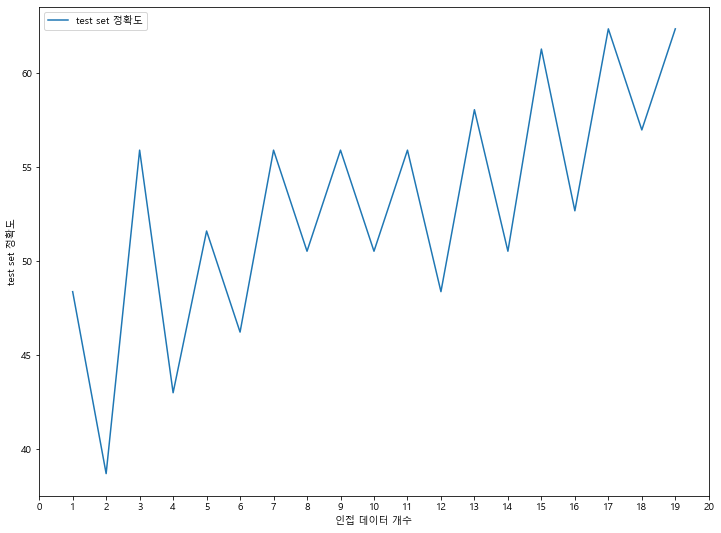

In [22]:
knn('SPY','1993-01-01','2023-11-22',0.75,20)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
훈련 정확도 : 72.66
테스트 정확도 : 51.61
훈련 정확도 : 71.22
테스트 정확도 : 46.24
훈련 정확도 : 71.94
테스트 정확도 : 55.91
훈련 정확도 : 70.14
테스트 정확도 : 50.54
훈련 정확도 : 69.78
테스트 정확도 : 55.91
훈련 정확도 : 67.63
테스트 정확도 : 50.54
훈련 정확도 : 66.19
테스트 정확도 : 55.91
훈련 정확도 : 66.55
테스트 정확도 : 48.39
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 66.55
테스트 정확도 : 50.54
훈련 정확도 : 66.91
테스트 정확도 : 61.29
훈련 정확도 : 65.47
테스트 정확도 : 52.69
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 68.71
테스트 정확도 : 56.99
훈련 정확도 : 65.83
테스트 정확도 : 62.37
훈련 정확도 : 67.27
테스트 정확도 : 55.91
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 64.39
테스트 정확도 : 61.29
훈련 정확도 : 64.39
테스트 정확도 : 63.44
최대 test set 정확도:  63.44086021505376


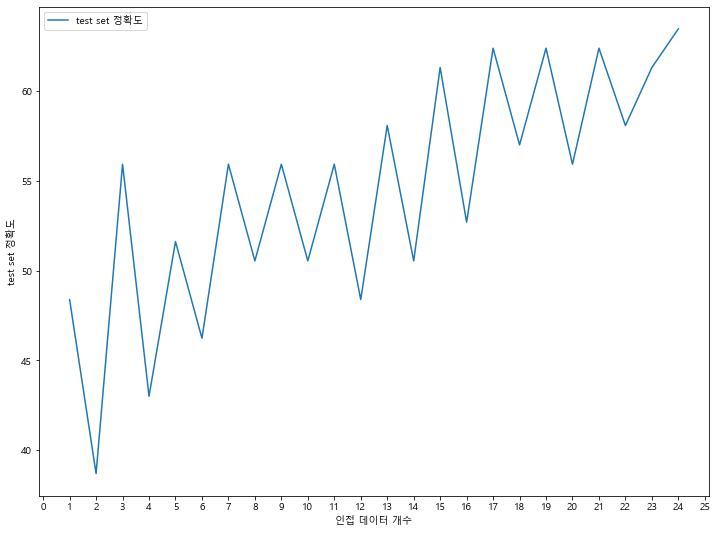

In [23]:
knn('SPY','1993-01-01','2023-11-22',0.75,25)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
훈련 정확도 : 72.66
테스트 정확도 : 51.61
훈련 정확도 : 71.22
테스트 정확도 : 46.24
훈련 정확도 : 71.94
테스트 정확도 : 55.91
훈련 정확도 : 70.14
테스트 정확도 : 50.54
훈련 정확도 : 69.78
테스트 정확도 : 55.91
훈련 정확도 : 67.63
테스트 정확도 : 50.54
훈련 정확도 : 66.19
테스트 정확도 : 55.91
훈련 정확도 : 66.55
테스트 정확도 : 48.39
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 66.55
테스트 정확도 : 50.54
훈련 정확도 : 66.91
테스트 정확도 : 61.29
훈련 정확도 : 65.47
테스트 정확도 : 52.69
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 68.71
테스트 정확도 : 56.99
훈련 정확도 : 65.83
테스트 정확도 : 62.37
훈련 정확도 : 67.27
테스트 정확도 : 55.91
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 64.39
테스트 정확도 : 61.29
훈련 정확도 : 64.39
테스트 정확도 : 63.44
훈련 정확도 : 65.11
테스트 정확도 : 64.52
훈련 정확도 : 64.75
테스트 정확도 : 62.37
훈련 정확도 : 65.83
테스트 정확도 : 67.74
훈련 정확도 : 65.83
테스트 정확도 : 61.29
훈련 정확도 : 64.75
테스트 정확도 : 63.44
최대 test set 정확도:  67.7419354838

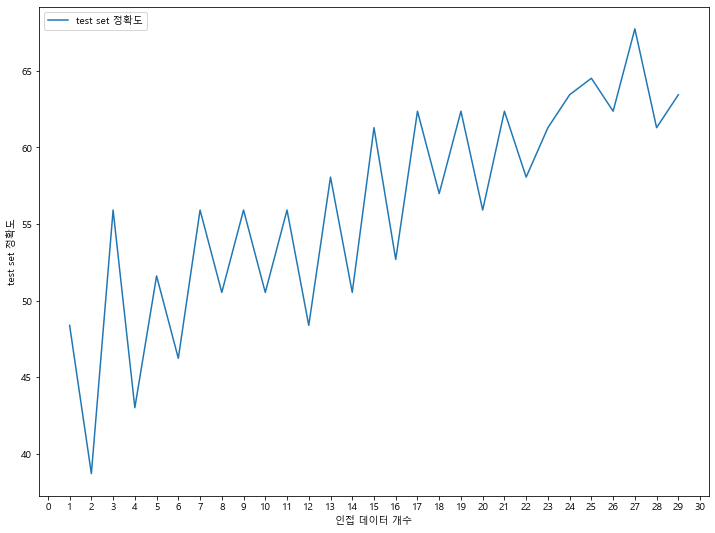

In [24]:
knn('SPY','1993-01-01','2023-11-22',0.75,30)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
훈련 정확도 : 72.66
테스트 정확도 : 51.61
훈련 정확도 : 71.22
테스트 정확도 : 46.24
훈련 정확도 : 71.94
테스트 정확도 : 55.91
훈련 정확도 : 70.14
테스트 정확도 : 50.54
훈련 정확도 : 69.78
테스트 정확도 : 55.91
훈련 정확도 : 67.63
테스트 정확도 : 50.54
훈련 정확도 : 66.19
테스트 정확도 : 55.91
훈련 정확도 : 66.55
테스트 정확도 : 48.39
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 66.55
테스트 정확도 : 50.54
훈련 정확도 : 66.91
테스트 정확도 : 61.29
훈련 정확도 : 65.47
테스트 정확도 : 52.69
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 68.71
테스트 정확도 : 56.99
훈련 정확도 : 65.83
테스트 정확도 : 62.37
훈련 정확도 : 67.27
테스트 정확도 : 55.91
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 64.39
테스트 정확도 : 61.29
훈련 정확도 : 64.39
테스트 정확도 : 63.44
훈련 정확도 : 65.11
테스트 정확도 : 64.52
훈련 정확도 : 64.75
테스트 정확도 : 62.37
훈련 정확도 : 65.83
테스트 정확도 : 67.74
훈련 정확도 : 65.83
테스트 정확도 : 61.29
훈련 정확도 : 64.75
테스트 정확도 : 63.44
훈련 정확도 : 64.75
테스트 정확도 : 61.29


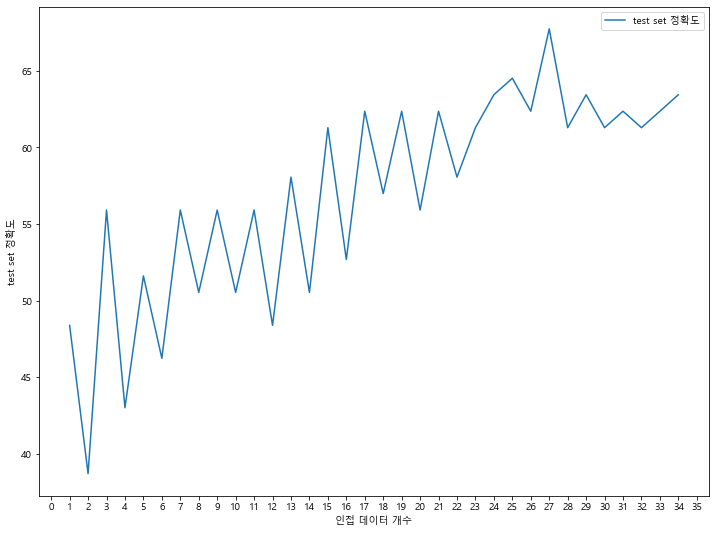

In [25]:
knn('SPY','1993-01-01','2023-11-22',0.75,35)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
훈련 정확도 : 72.66
테스트 정확도 : 51.61
훈련 정확도 : 71.22
테스트 정확도 : 46.24
훈련 정확도 : 71.94
테스트 정확도 : 55.91
훈련 정확도 : 70.14
테스트 정확도 : 50.54
훈련 정확도 : 69.78
테스트 정확도 : 55.91
훈련 정확도 : 67.63
테스트 정확도 : 50.54
훈련 정확도 : 66.19
테스트 정확도 : 55.91
훈련 정확도 : 66.55
테스트 정확도 : 48.39
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 66.55
테스트 정확도 : 50.54
훈련 정확도 : 66.91
테스트 정확도 : 61.29
훈련 정확도 : 65.47
테스트 정확도 : 52.69
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 68.71
테스트 정확도 : 56.99
훈련 정확도 : 65.83
테스트 정확도 : 62.37
훈련 정확도 : 67.27
테스트 정확도 : 55.91
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 64.39
테스트 정확도 : 61.29
훈련 정확도 : 64.39
테스트 정확도 : 63.44
훈련 정확도 : 65.11
테스트 정확도 : 64.52
훈련 정확도 : 64.75
테스트 정확도 : 62.37
훈련 정확도 : 65.83
테스트 정확도 : 67.74
훈련 정확도 : 65.83
테스트 정확도 : 61.29
훈련 정확도 : 64.75
테스트 정확도 : 63.44
훈련 정확도 : 64.75
테스트 정확도 : 61.29


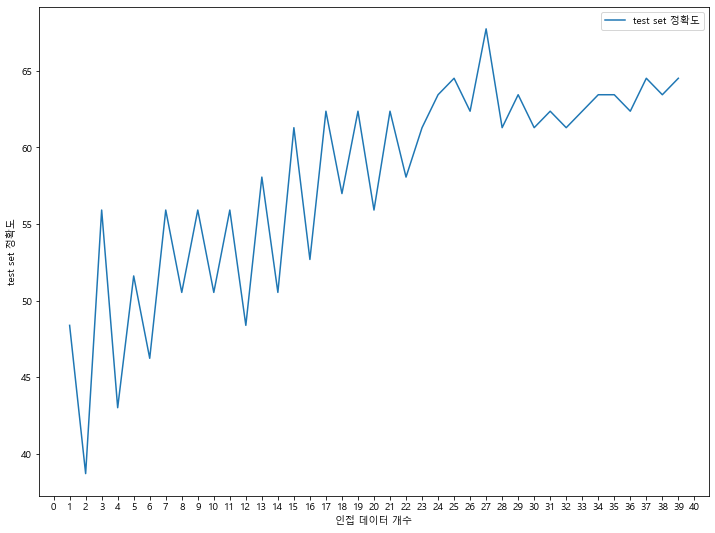

In [26]:
knn('SPY','1993-01-01','2023-11-22',0.75,40)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
훈련 정확도 : 72.66
테스트 정확도 : 51.61
훈련 정확도 : 71.22
테스트 정확도 : 46.24
훈련 정확도 : 71.94
테스트 정확도 : 55.91
훈련 정확도 : 70.14
테스트 정확도 : 50.54
훈련 정확도 : 69.78
테스트 정확도 : 55.91
훈련 정확도 : 67.63
테스트 정확도 : 50.54
훈련 정확도 : 66.19
테스트 정확도 : 55.91
훈련 정확도 : 66.55
테스트 정확도 : 48.39
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 66.55
테스트 정확도 : 50.54
훈련 정확도 : 66.91
테스트 정확도 : 61.29
훈련 정확도 : 65.47
테스트 정확도 : 52.69
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 68.71
테스트 정확도 : 56.99
훈련 정확도 : 65.83
테스트 정확도 : 62.37
훈련 정확도 : 67.27
테스트 정확도 : 55.91
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 64.39
테스트 정확도 : 61.29
훈련 정확도 : 64.39
테스트 정확도 : 63.44
훈련 정확도 : 65.11
테스트 정확도 : 64.52
훈련 정확도 : 64.75
테스트 정확도 : 62.37
훈련 정확도 : 65.83
테스트 정확도 : 67.74
훈련 정확도 : 65.83
테스트 정확도 : 61.29
훈련 정확도 : 64.75
테스트 정확도 : 63.44
훈련 정확도 : 64.75
테스트 정확도 : 61.29


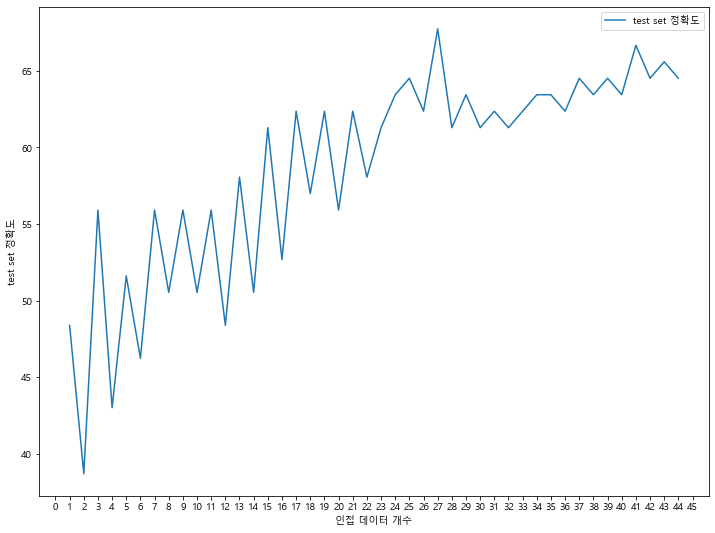

In [27]:
knn('SPY','1993-01-01','2023-11-22',0.75,45)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
훈련 정확도 : 72.66
테스트 정확도 : 51.61
훈련 정확도 : 71.22
테스트 정확도 : 46.24
훈련 정확도 : 71.94
테스트 정확도 : 55.91
훈련 정확도 : 70.14
테스트 정확도 : 50.54
훈련 정확도 : 69.78
테스트 정확도 : 55.91
훈련 정확도 : 67.63
테스트 정확도 : 50.54
훈련 정확도 : 66.19
테스트 정확도 : 55.91
훈련 정확도 : 66.55
테스트 정확도 : 48.39
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 66.55
테스트 정확도 : 50.54
훈련 정확도 : 66.91
테스트 정확도 : 61.29
훈련 정확도 : 65.47
테스트 정확도 : 52.69
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 68.71
테스트 정확도 : 56.99
훈련 정확도 : 65.83
테스트 정확도 : 62.37
훈련 정확도 : 67.27
테스트 정확도 : 55.91
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 64.39
테스트 정확도 : 61.29
훈련 정확도 : 64.39
테스트 정확도 : 63.44
훈련 정확도 : 65.11
테스트 정확도 : 64.52
훈련 정확도 : 64.75
테스트 정확도 : 62.37
훈련 정확도 : 65.83
테스트 정확도 : 67.74
훈련 정확도 : 65.83
테스트 정확도 : 61.29
훈련 정확도 : 64.75
테스트 정확도 : 63.44
훈련 정확도 : 64.75
테스트 정확도 : 61.29


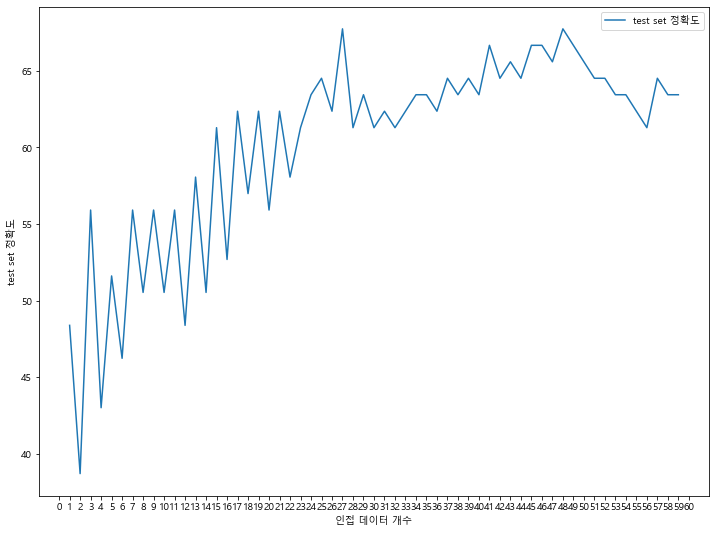

In [30]:
knn('SPY','1993-01-01','2023-11-22',0.75,60)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
훈련 정확도 : 72.66
테스트 정확도 : 51.61
훈련 정확도 : 71.22
테스트 정확도 : 46.24
훈련 정확도 : 71.94
테스트 정확도 : 55.91
훈련 정확도 : 70.14
테스트 정확도 : 50.54
훈련 정확도 : 69.78
테스트 정확도 : 55.91
훈련 정확도 : 67.63
테스트 정확도 : 50.54
훈련 정확도 : 66.19
테스트 정확도 : 55.91
훈련 정확도 : 66.55
테스트 정확도 : 48.39
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 66.55
테스트 정확도 : 50.54
훈련 정확도 : 66.91
테스트 정확도 : 61.29
훈련 정확도 : 65.47
테스트 정확도 : 52.69
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 68.71
테스트 정확도 : 56.99
훈련 정확도 : 65.83
테스트 정확도 : 62.37
훈련 정확도 : 67.27
테스트 정확도 : 55.91
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 64.39
테스트 정확도 : 61.29
훈련 정확도 : 64.39
테스트 정확도 : 63.44
훈련 정확도 : 65.11
테스트 정확도 : 64.52
훈련 정확도 : 64.75
테스트 정확도 : 62.37
훈련 정확도 : 65.83
테스트 정확도 : 67.74
훈련 정확도 : 65.83
테스트 정확도 : 61.29
훈련 정확도 : 64.75
테스트 정확도 : 63.44
훈련 정확도 : 64.75
테스트 정확도 : 61.29


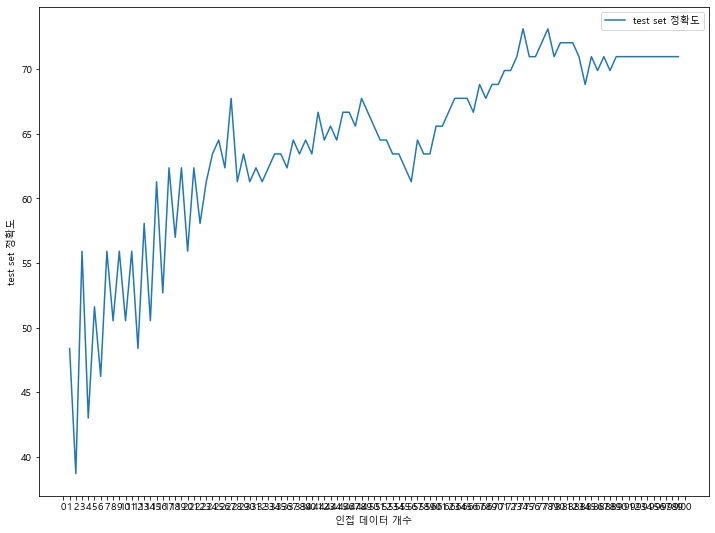

In [31]:
knn('SPY','1993-01-01','2023-11-22',0.75,100)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 48.39
훈련 정확도 : 75.90
테스트 정확도 : 38.71
훈련 정확도 : 78.06
테스트 정확도 : 55.91
훈련 정확도 : 69.42
테스트 정확도 : 43.01
훈련 정확도 : 72.66
테스트 정확도 : 51.61
훈련 정확도 : 71.22
테스트 정확도 : 46.24
훈련 정확도 : 71.94
테스트 정확도 : 55.91
훈련 정확도 : 70.14
테스트 정확도 : 50.54
훈련 정확도 : 69.78
테스트 정확도 : 55.91
훈련 정확도 : 67.63
테스트 정확도 : 50.54
훈련 정확도 : 66.19
테스트 정확도 : 55.91
훈련 정확도 : 66.55
테스트 정확도 : 48.39
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 66.55
테스트 정확도 : 50.54
훈련 정확도 : 66.91
테스트 정확도 : 61.29
훈련 정확도 : 65.47
테스트 정확도 : 52.69
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 68.71
테스트 정확도 : 56.99
훈련 정확도 : 65.83
테스트 정확도 : 62.37
훈련 정확도 : 67.27
테스트 정확도 : 55.91
훈련 정확도 : 66.19
테스트 정확도 : 62.37
훈련 정확도 : 66.55
테스트 정확도 : 58.06
훈련 정확도 : 64.39
테스트 정확도 : 61.29
훈련 정확도 : 64.39
테스트 정확도 : 63.44
훈련 정확도 : 65.11
테스트 정확도 : 64.52
훈련 정확도 : 64.75
테스트 정확도 : 62.37
훈련 정확도 : 65.83
테스트 정확도 : 67.74
훈련 정확도 : 65.83
테스트 정확도 : 61.29
훈련 정확도 : 64.75
테스트 정확도 : 63.44
훈련 정확도 : 64.75
테스트 정확도 : 61.29


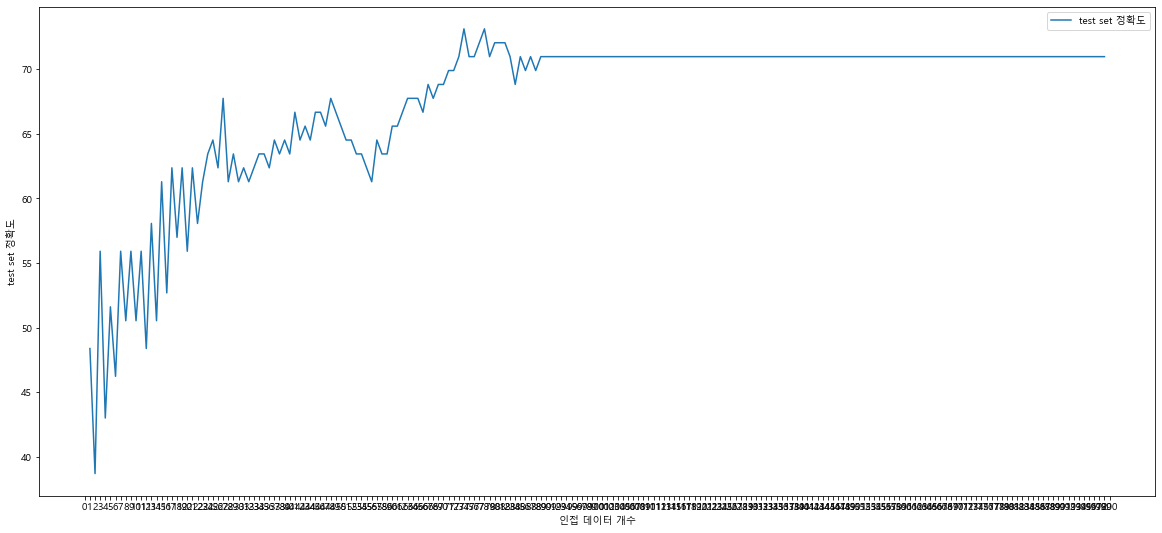

In [35]:
knn('SPY','1993-01-01','2023-11-22',0.75,200)

# 6.결과2

- k(인접 데이터)의 개수를 5부터 200까지 점차 늘려보았다. 
- 최대 test set 정확도를 가진 k값은 78이며, 최대 정확도는 73%였다. k의 범위가 5까지였을 때, 최대 정확도가 약 55%였다는 것을 보면, - k의 값을 어느 정도 늘리면, k의 값과 최대 정확도는 정비례한다는 사실을 알 수 있다.
- 하지만, k가 78을 넘어가는 시점에서 최대 정확도는 유의미하게 높아지지 않았으며, 어느 시점부터는 같은 최대 정확도값을 보였다.
- 이는 적정한 k값의 범위를 넘어가면 더 이상 k의 값을 늘리는 것이 의미가 많지 않다는 것을 보여준다.

# 7.정확도 분석(3): 데이터 기간(데이터량)에 따른 최대 정확도 조사

이번에는 야후 파이낸스에서 받아오는 데이터의 양을 점차 줄여나가서, 데이터 기간에 따른 최대 정확도를 조사해 볼 것이다.
원래는 1993년-2023년이었으나, 5년 단위로 받아오는 데이터의 양을 줄일 것이다.
또한, split_ratio의 값은 0.75로 고정할 것이다.
(30년 단위는 바로 위에서 실시했으므로 실행하지 않는다.)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 44.87
훈련 정확도 : 76.39
테스트 정확도 : 37.18
훈련 정확도 : 74.68
테스트 정확도 : 51.28
훈련 정확도 : 71.67
테스트 정확도 : 39.74
훈련 정확도 : 72.53
테스트 정확도 : 46.15
훈련 정확도 : 71.24
테스트 정확도 : 41.03
훈련 정확도 : 70.39
테스트 정확도 : 48.72
훈련 정확도 : 69.53
테스트 정확도 : 46.15
훈련 정확도 : 66.95
테스트 정확도 : 50.00
훈련 정확도 : 64.38
테스트 정확도 : 44.87
훈련 정확도 : 64.38
테스트 정확도 : 51.28
훈련 정확도 : 68.67
테스트 정확도 : 44.87
훈련 정확도 : 68.67
테스트 정확도 : 53.85
훈련 정확도 : 66.52
테스트 정확도 : 44.87
훈련 정확도 : 66.52
테스트 정확도 : 53.85
훈련 정확도 : 64.81
테스트 정확도 : 47.44
훈련 정확도 : 65.24
테스트 정확도 : 52.56
훈련 정확도 : 64.81
테스트 정확도 : 44.87
훈련 정확도 : 65.67
테스트 정확도 : 52.56
훈련 정확도 : 66.95
테스트 정확도 : 48.72
훈련 정확도 : 65.24
테스트 정확도 : 56.41
훈련 정확도 : 63.95
테스트 정확도 : 52.56
훈련 정확도 : 63.52
테스트 정확도 : 56.41
훈련 정확도 : 63.09
테스트 정확도 : 58.97
훈련 정확도 : 63.09
테스트 정확도 : 58.97
훈련 정확도 : 63.09
테스트 정확도 : 56.41
훈련 정확도 : 65.24
테스트 정확도 : 62.82
훈련 정확도 : 64.38
테스트 정확도 : 55.13
훈련 정확도 : 63.52
테스트 정확도 : 57.69
훈련 정확도 : 63.52
테스트 정확도 : 55.13


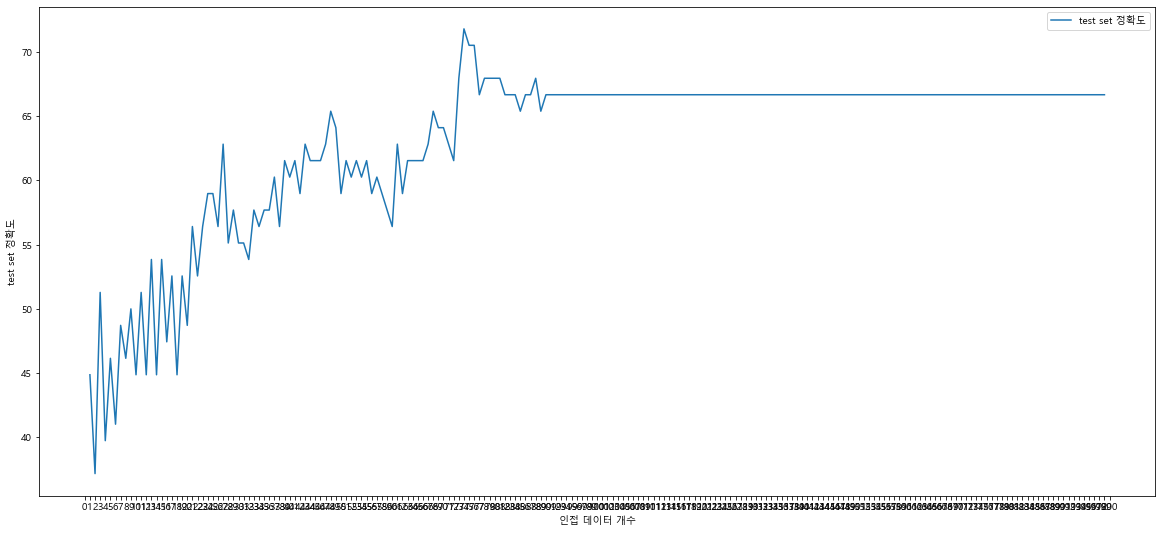

In [36]:
knn('SPY','1998-01-01','2023-11-22',0.75,200)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 42.86
훈련 정확도 : 80.85
테스트 정확도 : 31.75
훈련 정확도 : 77.66
테스트 정확도 : 60.32
훈련 정확도 : 74.47
테스트 정확도 : 50.79
훈련 정확도 : 69.68
테스트 정확도 : 53.97
훈련 정확도 : 69.68
테스트 정확도 : 46.03
훈련 정확도 : 69.68
테스트 정확도 : 44.44
훈련 정확도 : 68.09
테스트 정확도 : 42.86
훈련 정확도 : 68.62
테스트 정확도 : 52.38
훈련 정확도 : 66.49
테스트 정확도 : 49.21
훈련 정확도 : 66.49
테스트 정확도 : 53.97
훈련 정확도 : 67.02
테스트 정확도 : 52.38
훈련 정확도 : 68.62
테스트 정확도 : 61.90
훈련 정확도 : 67.02
테스트 정확도 : 53.97
훈련 정확도 : 66.49
테스트 정확도 : 57.14
훈련 정확도 : 65.43
테스트 정확도 : 58.73
훈련 정확도 : 67.02
테스트 정확도 : 58.73
훈련 정확도 : 69.15
테스트 정확도 : 60.32
훈련 정확도 : 69.15
테스트 정확도 : 63.49
훈련 정확도 : 68.62
테스트 정확도 : 63.49
훈련 정확도 : 69.15
테스트 정확도 : 65.08
훈련 정확도 : 68.62
테스트 정확도 : 65.08
훈련 정확도 : 67.55
테스트 정확도 : 61.90
훈련 정확도 : 67.02
테스트 정확도 : 61.90
훈련 정확도 : 68.09
테스트 정확도 : 60.32
훈련 정확도 : 68.09
테스트 정확도 : 61.90
훈련 정확도 : 68.09
테스트 정확도 : 60.32
훈련 정확도 : 67.55
테스트 정확도 : 61.90
훈련 정확도 : 67.55
테스트 정확도 : 61.90
훈련 정확도 : 67.02
테스트 정확도 : 61.90


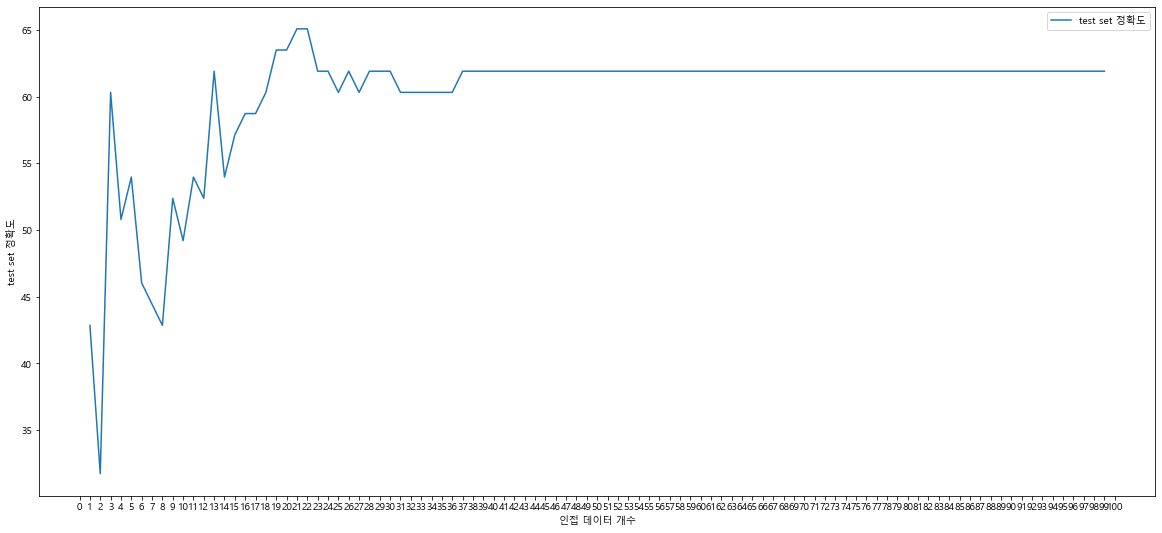

In [39]:
knn('SPY','2003-01-01','2023-11-22',0.75,100)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 39.58
훈련 정확도 : 80.42
테스트 정확도 : 31.25
훈련 정확도 : 75.52
테스트 정확도 : 50.00
훈련 정확도 : 72.03
테스트 정확도 : 43.75
훈련 정확도 : 72.03
테스트 정확도 : 47.92
훈련 정확도 : 66.43
테스트 정확도 : 43.75
훈련 정확도 : 67.83
테스트 정확도 : 50.00
훈련 정확도 : 66.43
테스트 정확도 : 47.92
훈련 정확도 : 68.53
테스트 정확도 : 47.92
훈련 정확도 : 69.23
테스트 정확도 : 50.00
훈련 정확도 : 67.83
테스트 정확도 : 54.17
훈련 정확도 : 69.23
테스트 정확도 : 52.08
훈련 정확도 : 69.23
테스트 정확도 : 50.00
훈련 정확도 : 65.73
테스트 정확도 : 47.92
훈련 정확도 : 67.13
테스트 정확도 : 64.58
훈련 정확도 : 67.13
테스트 정확도 : 54.17
훈련 정확도 : 67.83
테스트 정확도 : 58.33
훈련 정확도 : 69.23
테스트 정확도 : 54.17
훈련 정확도 : 68.53
테스트 정확도 : 58.33
훈련 정확도 : 69.93
테스트 정확도 : 56.25
훈련 정확도 : 67.83
테스트 정확도 : 56.25
훈련 정확도 : 67.83
테스트 정확도 : 56.25
훈련 정확도 : 67.83
테스트 정확도 : 56.25
훈련 정확도 : 67.83
테스트 정확도 : 56.25
훈련 정확도 : 67.83
테스트 정확도 : 56.25
훈련 정확도 : 67.83
테스트 정확도 : 56.25
훈련 정확도 : 67.83
테스트 정확도 : 58.33
훈련 정확도 : 67.83
테스트 정확도 : 56.25
훈련 정확도 : 67.83
테스트 정확도 : 58.33
훈련 정확도 : 67.83
테스트 정확도 : 56.25


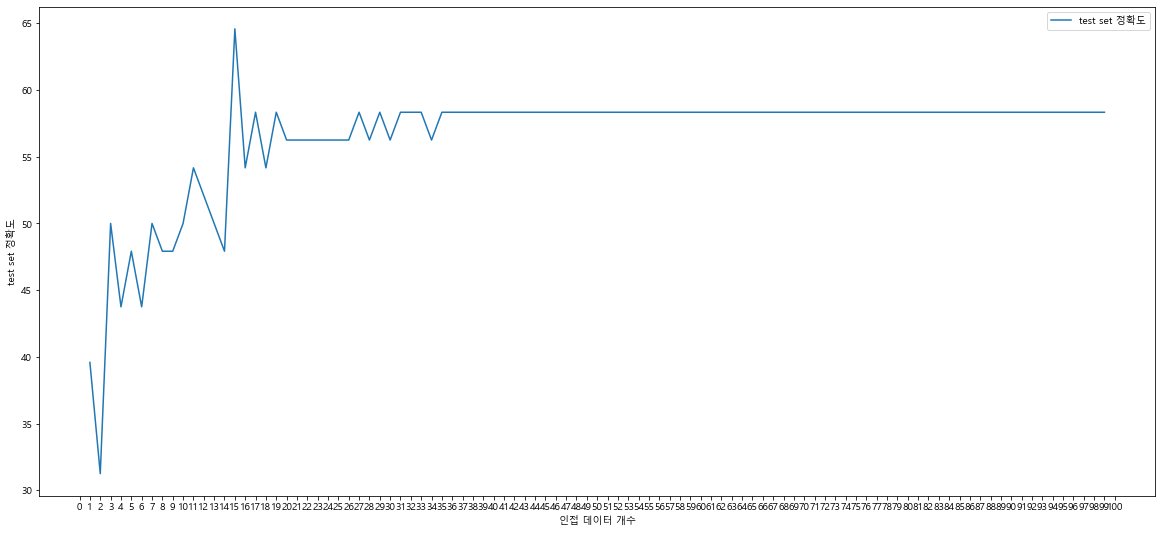

In [40]:
knn('SPY','2008-01-01','2023-11-22',0.75,100)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 57.58
훈련 정확도 : 78.57
테스트 정확도 : 42.42
훈련 정확도 : 78.57
테스트 정확도 : 60.61
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 76.53
테스트 정확도 : 66.67
훈련 정확도 : 71.43
테스트 정확도 : 63.64
훈련 정확도 : 73.47
테스트 정확도 : 60.61
훈련 정확도 : 76.53
테스트 정확도 : 60.61
훈련 정확도 : 73.47
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58
훈련 정확도 : 72.45
테스트 정확도 : 57.58


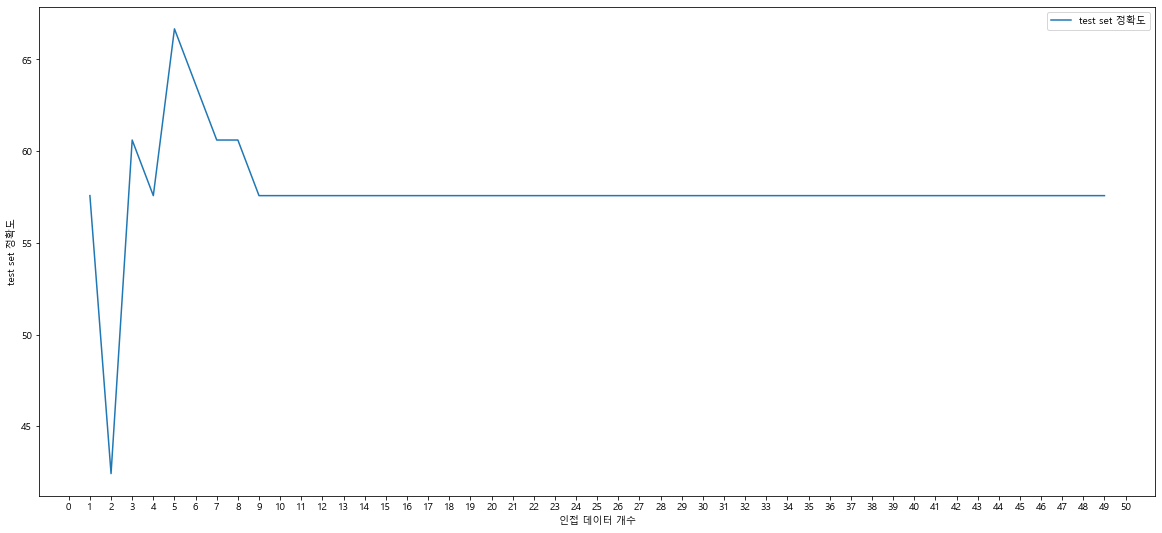

In [42]:
knn('SPY','2013-01-01','2023-11-22',0.75,50)

[*********************100%%**********************]  1 of 1 completed
훈련 정확도 : 100.00
테스트 정확도 : 38.89
훈련 정확도 : 77.36
테스트 정확도 : 38.89
훈련 정확도 : 77.36
테스트 정확도 : 50.00
훈련 정확도 : 67.92
테스트 정확도 : 50.00
훈련 정확도 : 73.58
테스트 정확도 : 55.56
훈련 정확도 : 67.92
테스트 정확도 : 55.56
훈련 정확도 : 69.81
테스트 정확도 : 50.00
훈련 정확도 : 71.70
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 50.00
훈련 정확도 : 66.04
테스트 정확도 : 50.00
훈련 정확도 : 69.81
테스트 정확도 : 55.56
훈련 정확도 : 71.70
테스트 정확도 : 61.11
훈련 정확도 : 66.04
테스트 정확도 : 61.11
훈련 정확도 : 67.92
테스트 정확도 : 61.11
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 67.92
테스트 정확도 : 61.11
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56
훈련 정확도 : 66.04
테스트 정확도 : 55.56


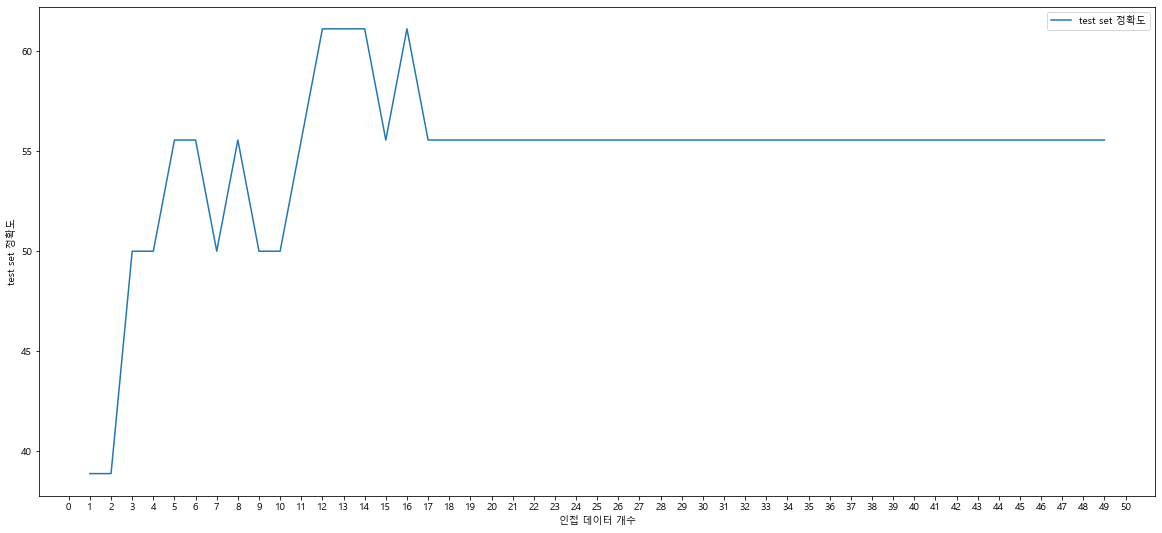

In [43]:
knn('SPY','2018-01-01','2023-11-22',0.75,50)

# 8.그래프 그리기

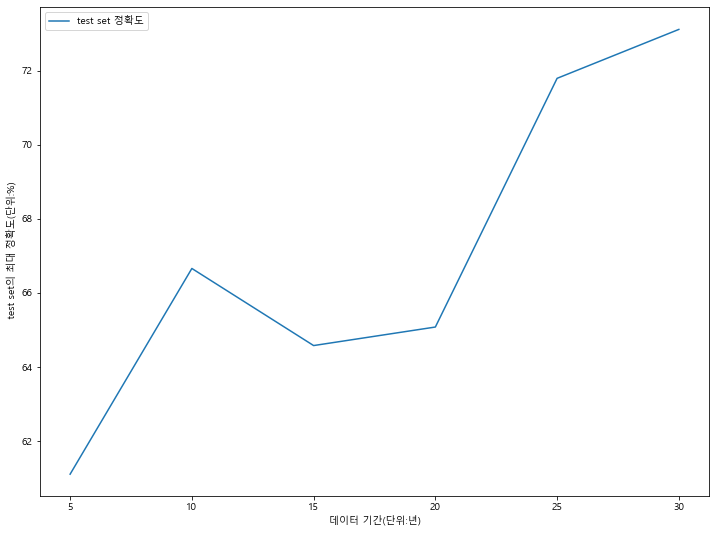

In [46]:
 plt.figure(figsize=(12,9))
plt.plot([5,10,15,20,25,30],[61.11,66.66,64.58,65.08,71.79,73.11],label='test set 정확도') 
plt.xlabel('데이터 기간(단위:년)') #x축에 제목을 붙인다.
plt.ylabel(" test set의 최대 정확도(단위:%)") #y축에 제목을 붙인다.
plt.legend()
plt.show()

# 9.결과3

- 데이터의 기간, 즉 크기가 커질수록 test set의 최대 정확도는 올라간다.(정비례한다.)
- 또한, 1,2,3의 결과를 보았을 때, 이 모델에서 최대로 낼 수 있는 정확도는 70프로 초중반대이다.(약 73%)

# 10. 최종 결론 및 인사이트

- 1.split_ratio는 너무 높게 설정하지도 않고, 너무 낮게 설정하지도 않는 것이 좋다. 약 0.75 정도가 좋다.
- 2. k의 개수는 일정 수준까지 올리면 높일수록 정확도가 정비례하지만, 너무 높이면 최대 정확도가 개선되지 않는다. 어느 정도까지 k의 값을 올리되, 정확도의 최고점을 찾으면, 굳이 k의 값을 늘릴 필요가 없다.
- 3. 데이터의 양은 많으면 많을 수록 좋다.

- 4. 보통 주가 분석 관련 knn의 정확도는 50프로 중후반대를 보이나, 적절한 split_ratio 값, k의 개수, 데이터의 양을 알아내면 정확도를 73% 정도까지 끌어 올릴 수 있다는 사실을 알 수 있다. 이는 우리가 관련 변수 및 데이터를 어떻게 다루느냐에 따라 모델의 정확도가 달라질 수 있음을 알 수 있다. 

- 5. knn을 절대 모멘텀 예측에 100프로 적용하는 것은 무리가 있을 수 있다. 최대 정확도가 70%초중반대이기 때문이다. 하지만, 보통 주가 예측 관련 knn의 정확도가 50프로대 중후반인 것을 감안할 때, 참고할 수 있는 지표정도는 될 수 있을 것이다.

- 6. 개선점: 더 많은 양을 가진 데이터를 찾는다면, knn의 정확도를 더 높일 수 있을 것이다.